/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


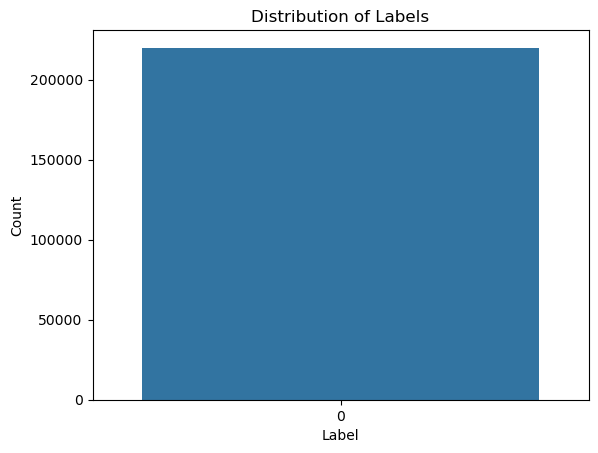

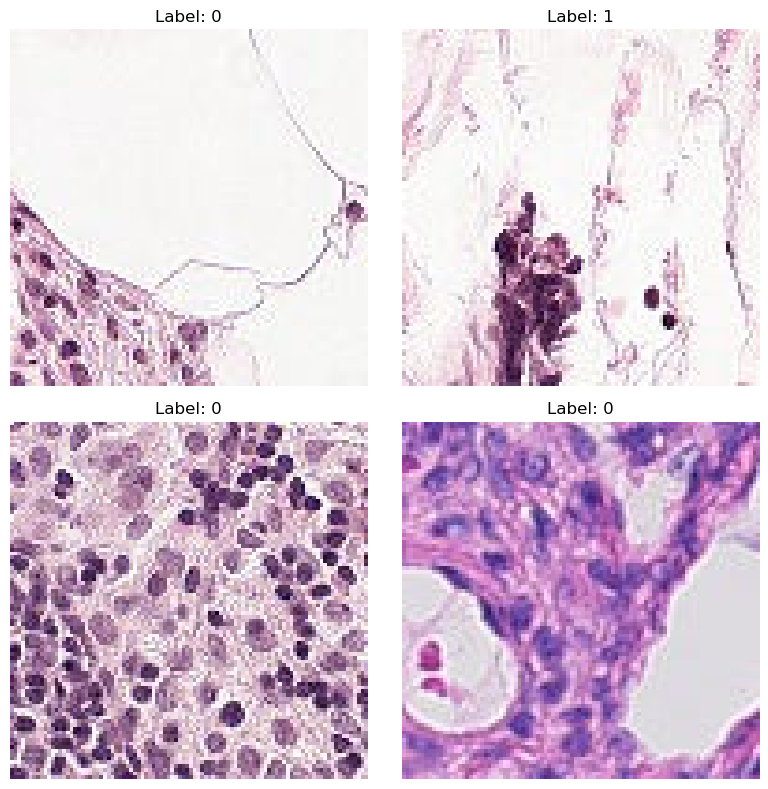

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load the train_labels.csv file
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Display the first few rows of the train_labels DataFrame
print(train_labels.head())

# Check the distribution of the target variable
sns.countplot(train_labels['label'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

# Load and display a few sample images
sample_images = train_labels.head(4)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

for idx, row in sample_images.iterrows():
    img_path = '/kaggle/input/histopathologic-cancer-detection/train/' + str(row['id']) + '.tif'
    img = Image.open(img_path)
    axes[idx//2, idx%2].imshow(img)
    axes[idx//2, idx%2].set_title('Label: ' + str(row['label']))
    axes[idx//2, idx%2].axis('off')

plt.tight_layout()
plt.show()

In [2]:
import os
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

train_path = "/kaggle/input/histopathologic-cancer-detection/train"
test_path = "/kaggle/input/histopathologic-cancer-detection/test"
output_path = "/kaggle/working"

train_labels = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
train_labels["filename"] = train_path + "/" + train_labels["id"] + ".tif"
train_labels["label"] = train_labels["label"].astype(str)

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_labels,
    x_col="filename",
    y_col="label",
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", input_shape=(96, 96, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model
model.fit(train_generator, epochs=1, validation_data=validation_generator)

# Generate predictions for the test set
test_files = os.listdir(test_path)
test_df = pd.DataFrame({
    "filename": [test_path + "/" + file for file in test_files]
})

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filename",
    y_col=None,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=32,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)

# Prepare the submission file
submission = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
submission["label"] = predictions.round().astype(int)
submission.to_csv(output_path + "/submission.csv", index=False)

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.
5501/5501 [==============================] - 2306s 419ms/step - loss: 0.3995 - accuracy: 0.8221 - val_loss: 0.3324 - val_accuracy: 0.8609
Found 57458 validated image filenames.
1796/1796 [==============================] - 334s 186ms/step
